## Benchmark for measuring performance of engineered features and models

Test benchmark 8, numeric features one by one

In [1]:
import sys
sys.path.insert(0, '../../bosch_helper')
from bosch_helper import *

%matplotlib inline

/c3se/NOBACKUP/users/lyaa/conda_dir/miniconda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### Load train and test data

In [2]:
# important numeric features are imported
important_features = pd.read_csv('../benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [3]:
x_train_numeric = pd.read_csv('../../data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [4]:
date_train = pd.read_csv('../benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

In [5]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

In [6]:
x_test_numeric = pd.read_csv('../../data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('../benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

In [7]:
x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

In [8]:
del x_train_numeric, x_test_numeric
gc.collect()

65

### Load benchmark_3 features

In [9]:
start_chunk = pd.read_csv('../benchmark_3/start_chunk.csv.gz', index_col=0)

start_chunk_train = start_chunk.loc[start_chunk.Response!=-1].drop(['Response'], axis=1)
start_chunk_test = start_chunk.loc[start_chunk.Response==-1].drop(['Response'], axis=1)

In [10]:
x_train = x_train.join(start_chunk_train, on='Id')
x_test = x_test.join(start_chunk_test, on='Id')

gc.collect()

35

### Load benchmark_4 features

In [11]:
n = pd.read_csv('../benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_train = x_train.join(neighbor_train, on='Id')
x_test = x_test.join(neighbor_test, on='Id')

gc.collect()

(1183748, 14) (1183747, 14)


28

### Add neighbor numeric features
The important numeric features selected from previous and next records

In [12]:
# Date + station flow data will be added to x
x = pd.concat([x_train, x_test], keys=['train', 'test'])
x.sort_index(axis=0, level='Id', inplace=True)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x['station_flow'] = le.fit_transform(x['station_flow'])

In [14]:
# Add the neighbor records
x = x.join(x.iloc[:, :150].shift(), rsuffix='_previous')
x = x.join(x.iloc[:, :150].shift(-1), rsuffix='_next')

In [15]:
x_train = x.loc['train']
x_test = x.loc['test']

del x
gc.collect()

63

### Load benchmark_7 features

Time series features

In [16]:
time_features = pd.read_hdf('../benchmark_7/time_features_diff.hdf', 'time_features')
time_features.drop(['time_start', 'time_end', 'time_duration', 'Response'], axis=1, inplace=True)

In [17]:
time_feature_names = time_features.iloc[:, :-40].columns.tolist()

In [18]:
# Do not use MeanTimeDiff features
x_train = x_train.join(time_features.loc['train', time_feature_names])
x_test = x_test.join(time_features.loc['test', time_feature_names])

In [19]:
print(x_train.shape, x_test.shape)

(1183747, 754) (1183748, 754)


In [20]:
del time_features
gc.collect()

121

### Load hash numeric features

In [21]:
#hash_numeric = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'hash_numeric')

In [22]:
#x_train = x_train.join(hash_numeric.loc['train'])
#x_test = x_test.join(hash_numeric.loc['test'])

### CV score based on stratified KFold with repeated models

In [23]:
# CV
# specify parameters 
# 'booster':'gbtree'
params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
         'base_score':0.0058, 'colsample_bytree':0.6}

# 'booster':'dart'
# params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
#         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'dart', 'alpha':0,
#         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6, 
#         'sample_type':'uniform', 'normalize_type':'tree', 'rate_drop':0.1, 'skip_drop':0.2, 'one_drop':True}

cv_results, clfs, running_time = cross_val_predict_skf_rm_xgb(params, x_train, y_train, 
                                                              num_boost_round=80, n_splits=5, 
                                                              n_repeats=3, random_state=5870577, 
                                                              verbose_eval=True)

results = {'clfs': clfs, 'cv_results': cv_results, 'running_time': running_time}
save_pickle(results, 'results_benchmark_8_hash_cv_1.pickle')

[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.3049	test-MCC:0.301217
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.336859	test-MCC:0.3346
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.375506	test-MCC:0.371554
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.379659	test-MCC:0.373782
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.380184	test-MCC:0.373729
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.386096	test-MCC:0.375849
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.390782	test-MCC:0.375358
[7]	train-error:0.005811	test-error:0.005812	train-MCC:0.402392	test-MCC:0.384418
[8]	train-error:0.005811	test-error:0.005812	train-MCC:0.415618	test-MCC:0.389751
[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.422129	test-MCC:0.397181
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.430091	test-MCC:0.39832
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.437475	test-MCC:0.404763
[12]	train-error:0.

[19]	train-error:0.005717	test-error:0.005681	train-MCC:0.471996	test-MCC:0.409159
[20]	train-error:0.005642	test-error:0.005605	train-MCC:0.474056	test-MCC:0.409616
[21]	train-error:0.005602	test-error:0.005571	train-MCC:0.478437	test-MCC:0.412354
[22]	train-error:0.005564	test-error:0.005537	train-MCC:0.481384	test-MCC:0.416264
[23]	train-error:0.005509	test-error:0.005449	train-MCC:0.483474	test-MCC:0.417886
[24]	train-error:0.005433	test-error:0.005373	train-MCC:0.486554	test-MCC:0.421499
[25]	train-error:0.005354	test-error:0.005288	train-MCC:0.489064	test-MCC:0.420657
[26]	train-error:0.005304	test-error:0.005259	train-MCC:0.492307	test-MCC:0.422186
[27]	train-error:0.00526	test-error:0.005216	train-MCC:0.495688	test-MCC:0.423166
[28]	train-error:0.005235	test-error:0.005204	train-MCC:0.497609	test-MCC:0.426796
[29]	train-error:0.005216	test-error:0.005157	train-MCC:0.498713	test-MCC:0.426389
[30]	train-error:0.005202	test-error:0.005136	train-MCC:0.499641	test-MCC:0.42765
[31]	t

[38]	train-error:0.005008	test-error:0.005102	train-MCC:0.5121	test-MCC:0.448477
[39]	train-error:0.004987	test-error:0.005077	train-MCC:0.512261	test-MCC:0.4492
[40]	train-error:0.004962	test-error:0.005052	train-MCC:0.514163	test-MCC:0.450773
[41]	train-error:0.004947	test-error:0.005035	train-MCC:0.515615	test-MCC:0.450128
[42]	train-error:0.004932	test-error:0.005026	train-MCC:0.516601	test-MCC:0.449677
[43]	train-error:0.00492	test-error:0.004988	train-MCC:0.51741	test-MCC:0.450168
[44]	train-error:0.004905	test-error:0.004984	train-MCC:0.517936	test-MCC:0.451154
[45]	train-error:0.004893	test-error:0.004976	train-MCC:0.520631	test-MCC:0.451382
[46]	train-error:0.004866	test-error:0.004971	train-MCC:0.522135	test-MCC:0.451479
[47]	train-error:0.004857	test-error:0.004955	train-MCC:0.523485	test-MCC:0.451379
[48]	train-error:0.004846	test-error:0.004946	train-MCC:0.524258	test-MCC:0.450105
[49]	train-error:0.00483	test-error:0.004933	train-MCC:0.525307	test-MCC:0.451918
[50]	train-

[57]	train-error:0.004677	test-error:0.004849	train-MCC:0.549798	test-MCC:0.449264
[58]	train-error:0.004664	test-error:0.004841	train-MCC:0.552841	test-MCC:0.450631
[59]	train-error:0.004652	test-error:0.004841	train-MCC:0.554594	test-MCC:0.450621
[60]	train-error:0.004641	test-error:0.004836	train-MCC:0.555241	test-MCC:0.451602
[61]	train-error:0.004636	test-error:0.004824	train-MCC:0.557073	test-MCC:0.450465
[62]	train-error:0.00462	test-error:0.004811	train-MCC:0.55932	test-MCC:0.452031
[63]	train-error:0.004616	test-error:0.004798	train-MCC:0.562202	test-MCC:0.452031
[64]	train-error:0.004608	test-error:0.004794	train-MCC:0.564839	test-MCC:0.450888
[65]	train-error:0.004593	test-error:0.004786	train-MCC:0.567104	test-MCC:0.451997
[66]	train-error:0.00459	test-error:0.004781	train-MCC:0.568542	test-MCC:0.452408
[67]	train-error:0.004578	test-error:0.004786	train-MCC:0.570207	test-MCC:0.453568
[68]	train-error:0.004572	test-error:0.004786	train-MCC:0.573843	test-MCC:0.45298
[69]	tra

[76]	train-error:0.004522	test-error:0.004659	train-MCC:0.566406	test-MCC:0.460557
[77]	train-error:0.004522	test-error:0.004659	train-MCC:0.566876	test-MCC:0.460295
[78]	train-error:0.004516	test-error:0.004651	train-MCC:0.568574	test-MCC:0.461019
[79]	train-error:0.004512	test-error:0.004642	train-MCC:0.570385	test-MCC:0.461442
Repeat 0, split 4, test MCC = 0.461, running time = 6.507 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.268364	test-MCC:0.251232
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.332595	test-MCC:0.312318
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.352707	test-MCC:0.348907
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.373072	test-MCC:0.366133
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.387314	test-MCC:0.372142
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.393906	test-MCC:0.382437
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.41116	test-MCC:0.39663
[7]	train-error:0.005811	test-erro

[14]	train-error:0.005811	test-error:0.005812	train-MCC:0.456336	test-MCC:0.407558
[15]	train-error:0.005811	test-error:0.005812	train-MCC:0.460398	test-MCC:0.412334
[16]	train-error:0.005811	test-error:0.005812	train-MCC:0.463586	test-MCC:0.420138
[17]	train-error:0.005808	test-error:0.005808	train-MCC:0.469382	test-MCC:0.424892
[18]	train-error:0.005807	test-error:0.005804	train-MCC:0.472042	test-MCC:0.428012
[19]	train-error:0.005799	test-error:0.005804	train-MCC:0.474604	test-MCC:0.431254
[20]	train-error:0.005793	test-error:0.005799	train-MCC:0.477126	test-MCC:0.436012
[21]	train-error:0.005709	test-error:0.005719	train-MCC:0.478999	test-MCC:0.435852
[22]	train-error:0.00566	test-error:0.005698	train-MCC:0.481939	test-MCC:0.434921
[23]	train-error:0.005598	test-error:0.00566	train-MCC:0.48485	test-MCC:0.437566
[24]	train-error:0.005543	test-error:0.005597	train-MCC:0.486387	test-MCC:0.437578
[25]	train-error:0.005479	test-error:0.005537	train-MCC:0.489132	test-MCC:0.437782
[26]	tr

[33]	train-error:0.005093	test-error:0.005204	train-MCC:0.492403	test-MCC:0.451783
[34]	train-error:0.00506	test-error:0.005178	train-MCC:0.495339	test-MCC:0.451754
[35]	train-error:0.005037	test-error:0.005157	train-MCC:0.4967	test-MCC:0.453092
[36]	train-error:0.005007	test-error:0.005119	train-MCC:0.497579	test-MCC:0.452876
[37]	train-error:0.004974	test-error:0.005098	train-MCC:0.500936	test-MCC:0.450111
[38]	train-error:0.00495	test-error:0.005073	train-MCC:0.503715	test-MCC:0.451783
[39]	train-error:0.004929	test-error:0.00506	train-MCC:0.504695	test-MCC:0.450601
[40]	train-error:0.004912	test-error:0.005043	train-MCC:0.507519	test-MCC:0.451321
[41]	train-error:0.004898	test-error:0.005014	train-MCC:0.510651	test-MCC:0.452197
[42]	train-error:0.004875	test-error:0.004993	train-MCC:0.511418	test-MCC:0.454524
[43]	train-error:0.004864	test-error:0.004988	train-MCC:0.512443	test-MCC:0.454968
[44]	train-error:0.004849	test-error:0.004971	train-MCC:0.514742	test-MCC:0.454745
[45]	trai

[52]	train-error:0.004743	test-error:0.004917	train-MCC:0.535708	test-MCC:0.449834
[53]	train-error:0.00473	test-error:0.004883	train-MCC:0.537548	test-MCC:0.450033
[54]	train-error:0.004712	test-error:0.004879	train-MCC:0.542378	test-MCC:0.450676
[55]	train-error:0.004706	test-error:0.004874	train-MCC:0.545681	test-MCC:0.45053
[56]	train-error:0.004686	test-error:0.00487	train-MCC:0.547419	test-MCC:0.450033
[57]	train-error:0.004672	test-error:0.004857	train-MCC:0.548678	test-MCC:0.450501
[58]	train-error:0.004663	test-error:0.004853	train-MCC:0.551911	test-MCC:0.450662
[59]	train-error:0.004646	test-error:0.004841	train-MCC:0.554331	test-MCC:0.451293
[60]	train-error:0.004634	test-error:0.004836	train-MCC:0.557962	test-MCC:0.45443
[61]	train-error:0.004622	test-error:0.004836	train-MCC:0.560538	test-MCC:0.453379
[62]	train-error:0.004617	test-error:0.004828	train-MCC:0.561593	test-MCC:0.453379
[63]	train-error:0.00461	test-error:0.004824	train-MCC:0.562334	test-MCC:0.452392
[64]	trai

[71]	train-error:0.004567	test-error:0.004689	train-MCC:0.578835	test-MCC:0.46231
[72]	train-error:0.00456	test-error:0.004684	train-MCC:0.579725	test-MCC:0.462635
[73]	train-error:0.004549	test-error:0.00468	train-MCC:0.58215	test-MCC:0.462377
[74]	train-error:0.004543	test-error:0.00468	train-MCC:0.584055	test-MCC:0.462448
[75]	train-error:0.004537	test-error:0.004672	train-MCC:0.584633	test-MCC:0.461311
[76]	train-error:0.004531	test-error:0.004672	train-MCC:0.586178	test-MCC:0.462898
[77]	train-error:0.004523	test-error:0.004667	train-MCC:0.587354	test-MCC:0.462403
[78]	train-error:0.004522	test-error:0.004667	train-MCC:0.588793	test-MCC:0.462057
[79]	train-error:0.004513	test-error:0.004642	train-MCC:0.590564	test-MCC:0.461387
Repeat 1, split 4, test MCC = 0.461, running time = 6.525 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.269711	test-MCC:0.249617
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.311379	test-MCC:0.286411
[2]	train-error:0.005811	test-er

[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.441646	test-MCC:0.420482
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.444689	test-MCC:0.422527
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.448933	test-MCC:0.427395
[12]	train-error:0.005811	test-error:0.005812	train-MCC:0.450462	test-MCC:0.430076
[13]	train-error:0.005811	test-error:0.005812	train-MCC:0.455986	test-MCC:0.433765
[14]	train-error:0.005811	test-error:0.005812	train-MCC:0.459113	test-MCC:0.435235
[15]	train-error:0.005811	test-error:0.005812	train-MCC:0.46315	test-MCC:0.43436
[16]	train-error:0.005811	test-error:0.005812	train-MCC:0.468551	test-MCC:0.436329
[17]	train-error:0.005808	test-error:0.005812	train-MCC:0.47114	test-MCC:0.437928
[18]	train-error:0.00576	test-error:0.005774	train-MCC:0.473832	test-MCC:0.438429
[19]	train-error:0.005728	test-error:0.005753	train-MCC:0.474421	test-MCC:0.4407
[20]	train-error:0.005696	test-error:0.005719	train-MCC:0.477017	test-MCC:0.441901
[21]	train-

[28]	train-error:0.005322	test-error:0.005428	train-MCC:0.488284	test-MCC:0.437131
[29]	train-error:0.005272	test-error:0.005377	train-MCC:0.492372	test-MCC:0.439132
[30]	train-error:0.005216	test-error:0.005335	train-MCC:0.492503	test-MCC:0.441231
[31]	train-error:0.005175	test-error:0.005276	train-MCC:0.494802	test-MCC:0.441719
[32]	train-error:0.005117	test-error:0.005246	train-MCC:0.497746	test-MCC:0.444761
[33]	train-error:0.005073	test-error:0.005212	train-MCC:0.498646	test-MCC:0.44569
[34]	train-error:0.005044	test-error:0.005178	train-MCC:0.499649	test-MCC:0.447052
[35]	train-error:0.005017	test-error:0.005149	train-MCC:0.502535	test-MCC:0.449628
[36]	train-error:0.005003	test-error:0.005136	train-MCC:0.504088	test-MCC:0.449798
[37]	train-error:0.00497	test-error:0.005119	train-MCC:0.505815	test-MCC:0.449552
[38]	train-error:0.004947	test-error:0.005094	train-MCC:0.506548	test-MCC:0.449895
[39]	train-error:0.004923	test-error:0.005073	train-MCC:0.508375	test-MCC:0.450118
[40]	t

[47]	train-error:0.004767	test-error:0.004917	train-MCC:0.52022	test-MCC:0.447592
[48]	train-error:0.004752	test-error:0.004891	train-MCC:0.521029	test-MCC:0.450817
[49]	train-error:0.004736	test-error:0.004883	train-MCC:0.521782	test-MCC:0.449058
[50]	train-error:0.004724	test-error:0.004883	train-MCC:0.523235	test-MCC:0.448653
[51]	train-error:0.004711	test-error:0.00487	train-MCC:0.524074	test-MCC:0.449834
[52]	train-error:0.004702	test-error:0.00487	train-MCC:0.524694	test-MCC:0.44885
[53]	train-error:0.004684	test-error:0.004841	train-MCC:0.525352	test-MCC:0.449134
[54]	train-error:0.004668	test-error:0.004828	train-MCC:0.526779	test-MCC:0.448777
[55]	train-error:0.004655	test-error:0.004815	train-MCC:0.529915	test-MCC:0.449926
[56]	train-error:0.004653	test-error:0.004803	train-MCC:0.530475	test-MCC:0.450047
[57]	train-error:0.004644	test-error:0.00479	train-MCC:0.531497	test-MCC:0.451333
[58]	train-error:0.00464	test-error:0.004781	train-MCC:0.533138	test-MCC:0.451333
[59]	train

[66]	train-error:0.004589	test-error:0.004765	train-MCC:0.567834	test-MCC:0.465356
[67]	train-error:0.004584	test-error:0.00476	train-MCC:0.568839	test-MCC:0.466083
[68]	train-error:0.004579	test-error:0.00476	train-MCC:0.571252	test-MCC:0.466662
[69]	train-error:0.004574	test-error:0.004748	train-MCC:0.574543	test-MCC:0.465062
[70]	train-error:0.004566	test-error:0.004743	train-MCC:0.576515	test-MCC:0.464333
[71]	train-error:0.004559	test-error:0.004739	train-MCC:0.578178	test-MCC:0.464199
[72]	train-error:0.004552	test-error:0.004731	train-MCC:0.579699	test-MCC:0.463912
[73]	train-error:0.004545	test-error:0.004722	train-MCC:0.581162	test-MCC:0.464061
[74]	train-error:0.004542	test-error:0.004727	train-MCC:0.583993	test-MCC:0.463912
[75]	train-error:0.004537	test-error:0.004727	train-MCC:0.58637	test-MCC:0.464645
[76]	train-error:0.004534	test-error:0.004722	train-MCC:0.588511	test-MCC:0.464184
[77]	train-error:0.004524	test-error:0.004727	train-MCC:0.591399	test-MCC:0.465663
[78]	tr

In [24]:
cv_train_mean = cv_results['train'].mean(axis=1)
cv_train_std = cv_results['train'].std(axis=1)
cv_test_mean = cv_results['test'].mean(axis=1)
cv_test_std = cv_results['test'].std(axis=1)

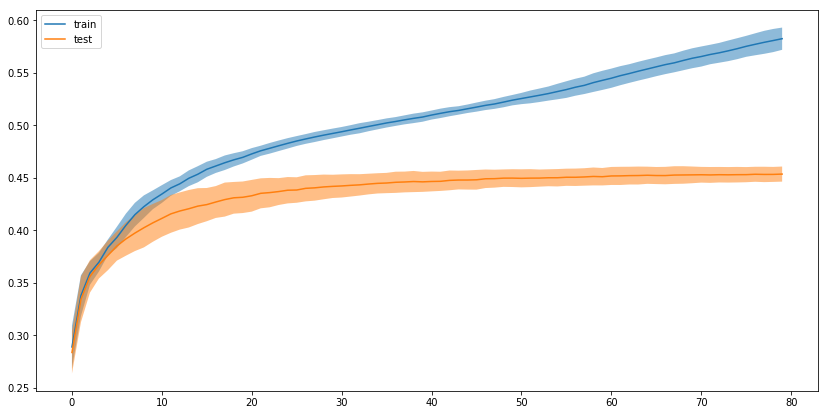

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(cv_train_mean)), cv_train_mean)
plt.fill_between(np.arange(len(cv_train_mean)), cv_train_mean-cv_train_std, cv_train_mean+cv_train_std, alpha=0.5)
plt.plot(np.arange(len(cv_train_mean)), cv_test_mean)
plt.fill_between(np.arange(len(cv_test_mean)), cv_test_mean-cv_test_std, cv_test_mean+cv_test_std, alpha=0.5)
plt.legend(['train', 'test'])

[0]	train-error:0.005811	train-MCC:0.314437
[1]	train-error:0.005811	train-MCC:0.3386
[2]	train-error:0.005811	train-MCC:0.369991
[3]	train-error:0.005811	train-MCC:0.37682
[4]	train-error:0.005811	train-MCC:0.381712
[5]	train-error:0.005811	train-MCC:0.386315
[6]	train-error:0.005811	train-MCC:0.400422
[7]	train-error:0.005811	train-MCC:0.415169
[8]	train-error:0.005811	train-MCC:0.427719
[9]	train-error:0.005811	train-MCC:0.435261
[10]	train-error:0.005811	train-MCC:0.441734
[11]	train-error:0.005811	train-MCC:0.450533
[12]	train-error:0.005811	train-MCC:0.453993
[13]	train-error:0.005811	train-MCC:0.459678
[14]	train-error:0.005811	train-MCC:0.463946
[15]	train-error:0.005811	train-MCC:0.467919
[16]	train-error:0.005811	train-MCC:0.469607
[17]	train-error:0.005809	train-MCC:0.472873
[18]	train-error:0.005802	train-MCC:0.475189
[19]	train-error:0.005793	train-MCC:0.477328
[20]	train-error:0.005745	train-MCC:0.47795
[21]	train-error:0.00571	train-MCC:0.480433
[22]	train-error:0.005667

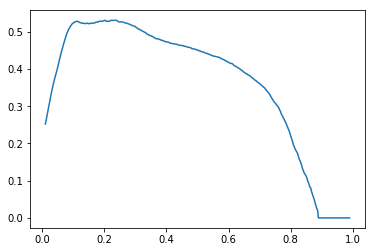

In [26]:
# Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
params['seed'] = 28537894
clf = xgb.train(params, dtrain, num_boost_round=60,
               feval=mcc_eval, evals=[(dtrain, 'train')])

y_train_pred = clf.predict(dtrain)

# Find best threshold 
thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

### Predict on test data

In [27]:
dtest = xgb.DMatrix(x_test)
y_test_pred = clf.predict(dtest)
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("../../data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("benchmark_8_submission_hash_1.csv.gz", compression="gzip")

Only With MeanTimeDiff Features:
- LB: `n_estimators=60`: Private MCC = 0.44401, public MCC = 0.43569
- CV: `n_estimators=80`: Score mean = 0.448, std = 0.013
- CV: `n_estimators=60`: Score mean = 0.445491, std = 0.0133, MCC~[0.43218, 0.45880]

Time series features, excluding MeanTimeDiff:
- LB: `n_estimators=60`: Private MCC = 0.46212, public MCC = 0.44761
- CV: `n_estimators=80`: Score mean = 0.454509, std = 0.00586
- CV: `n_estimators=60`: Score mean = 0.4534794, std = 0.0067, MCC~[0.44682, 0.46014]

Time series features, including MeanTimeDiff:
- LB: `n_estimators=60`: Private MCC = 0.43169, public MCC = 0.42776
- CV: `n_estimators=80`: Score mean = 0.452, std = 0.009
- CV: `n_estimators=60`: Score mean = 0.449, std = 0.009, MCC~[0.440109, 0.458029]
- Apparently overfitting since CV is higher than LB

In [28]:
cv_test_mean[60]+cv_test_std[60]

cv_test_mean[60]-cv_test_std[60]

cv_test_mean[79]

cv_test_std[60]

0.008573770361371